In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pickle
import matplotlib.pyplot as plt
import scipy.stats as scp
import seaborn as sns


In [8]:
weeklies, movielibrary, imdb = pickle.load(open("Processed_data.p", "rb"))
imdb

,index_name,Release Date,Metacritic Critic Score,Director,Cast,IMDB's Budget
0,Guardians of the Galaxy,None,76.0,James Gunn,"[\n Chris Pratt\n , \n Zoe Saldana\n , \n Dave...","\nBudget:$170,000,000\n (estimated)\n"
1,The Hobbit: The Battle of the Five Armies,None,59.0,Peter Jackson,"[\n Ian McKellen\n , \n Martin Freeman\n , \n ...","\nBudget:$250,000,000\n (estimated)\n"
2,Transformers: Age of Extinction,None,32.0,Michael Bay,"[\n Mark Wahlberg\n , \n Stanley Tucci\n , \n ...","\nBudget:$210,000,000\n (estimated)\n"
3,Maleficent,None,56.0,Robert Stromberg,"[\n Angelina Jolie\n , \n Elle Fanning\n , \n ...","\nBudget:$180,000,000\n (estimated)\n"
4,X-Men: Days of Future Past,None,75.0,Bryan Singer,"[\n Hugh Jackman\n , \n James McAvoy\n , \n Mi...","\nBudget:$200,000,000\n (estimated)\n"
...,...,...,...,...,...,...
2524,Joan the Maid 1: The Battles,None,52.0,Felix Randau,None,None
2525,TINY: The Life of Erin Blackwell,None,NaN,François Margolin,"[\n Oumar Ould Hamaha\n , \n François Margolin...",None
2526,I Lost Albert2019 Re-release,None,NaN,Joan Micklin Silver,"[\n Jerry Stiller\n , \n Anne Meara\n , \n Mar...",None
2527,In Safe Hands,None,NaN,Christopher Munch,"[\n David Angus\n , \n Ian Hart\n , \n Stephan...",None


In [9]:
names = set(movielibrary["index_name"])
weekly_names = set(weeklies["index_name"])

In [13]:
def weeks_above_cutoff(cutoff, df, min_weeks):
    """
    Identifies the target variable, "number of weeks for which the average box office was above a target variable."
    Screens out movies for which there are less than min_weeks of data.
    
    """
    compiled_weeklies = []
    for name in set(df["index_name"]):
        movie_df = df[df["index_name"]==name]
        if(movie_df["Avg"].count()>=min_weeks):
            fake_name = name


            real_name = movie_df["Name"].iloc[0]
            
            #Added 1 to allow boxcox to function if the movie never was above the cutoff in any week.
            num_above_cutoff = (movie_df["Avg"]>cutoff).sum()

            first_week = movie_df["Week"].min()
                                
#             first_week = movie_df["Week"].min()
            
#             num_above_cutoff = movie_df[movie_df["Avg"]>cutoff].Week.max() - first_week
    

            first_two_weeks = movie_df[movie_df["Week"]<=1+first_week]
            theaters_in_two_weeks = first_two_weeks["Theaters"].max().replace(",","")
            if theaters_in_two_weeks == "-":
                theaters_in_two_weeks = None
            else:
                theaters_in_two_weeks = int(theaters_in_two_weeks)
            avg_BO_two_weeks_sum = first_two_weeks["Avg"].sum()

            compiled_weeklies.append([fake_name, real_name, num_above_cutoff, theaters_in_two_weeks, avg_BO_two_weeks_sum])
    return pd.DataFrame(data=compiled_weeklies, columns=["REAL name", "index_name", "Longevity", "2 wk Theaters", "2 wk Box Office"])


#Metric of 800 dollars selected. On average, movies drop below 800 dollars weekly per-theater after 8 weeks. 
weeks_to_dropoff_df = weeks_above_cutoff(800, weeklies, 4)
merged = weeks_to_dropoff_df.merge(movielibrary, how="left").merge(imdb, how="left")

Text(3.674999999999997, 0.5, 'Count')

<Figure size 216x216 with 0 Axes>

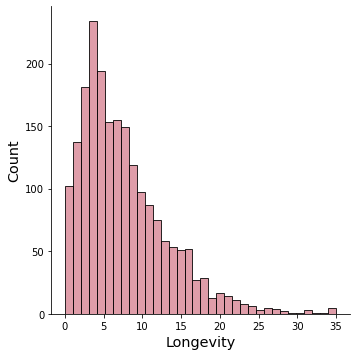

In [14]:
friendlyred = '#d57d8d'

#Remove outliers that can be iedentified early
merged = merged[merged["Longevity"]<40]
plt.figure(figsize=(3,3))
sns.displot(data=merged, x="Longevity", color=friendlyred, bins=34)
plt.xlabel("Longevity", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")

Text(3.674999999999997, 0.5, 'Count')

<Figure size 216x216 with 0 Axes>

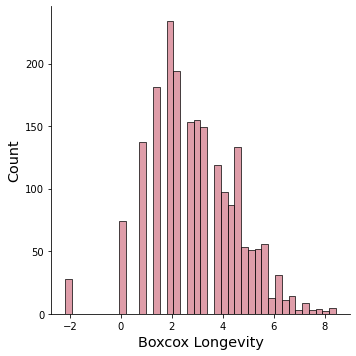

In [15]:
#Because longevity is a heavily skewed metric, I correct it with a boxcox transformation.

plt.figure(figsize=(3,3))
merged["Boxcox Longevity"], lamb = scp.boxcox(merged["Longevity"]+0.001)
sns.displot(data=merged, x="Boxcox Longevity", color=friendlyred, bins=40)
plt.xlabel("Boxcox Longevity", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")

In [32]:
merged

,REAL name,index_name,Longevity,2 wk Theaters,2 wk Box Office,index,Budget,MPAA,Genres,Domestic Opening,...,Sport,Thriller,War,Western,Release Date,Metacritic Critic Score,Director,Cast,IMDB's Budget,Boxcox Longevity
0,Rebel Without a Cause2018 Re-release,The Final Year,4,39.0,4213,1857.0,None,None,"{, Family, Adventure, Action, Fantasy}",None,...,False,False,False,False,None,51.0,Soi Cheang,"[\n Aaron Kwok\n , \n Shaofeng Feng\n , \n Zan...","\nBudget:$73,000,000\n (estimated)\n",1.899621
1,Mustang,Sleeping with Other People,3,5.0,27635,519.0,None,PG,"{, Documentary, Music}",None,...,False,False,False,False,None,67.0,Denny Tedesco,"[\n Denny Tedesco\n , \n Brian Wilson\n , \n D...",None,1.406972
2,She's Funny That Way,1915,9,9.0,6500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.668830
3,Sorry to Bother You,Mortal Engines,2,3103.0,4399,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.808953
4,Love on the Cloud,Love on the Cloud,5,17.0,12701,158.0,None,None,{Comedy},None,...,False,False,False,False,None,NaN,Changwei Gu,None,None,2.326297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,The Breadwinner,Happy End,9,3.0,23197,1379.0,None,R,{Comedy},None,...,False,False,False,False,None,43.0,Lake Bell,None,None,3.668830
2046,Little Italy,The Miseducation of Cameron Post,8,25.0,44890,1766.0,None,None,"{, Romance, Drama}",None,...,False,False,False,False,None,74.0,Ofir Raul Graizer,"[\n Tim Kalkhof\n , \n Sarah Adler\n , \n Roy ...",None,3.371784
2047,Infliction,Infliction,3,1.0,816,350.0,None,None,{Horror},None,...,False,False,False,False,None,NaN,Jack Thomas Smith,"[\n Jason Mac\n , \n Elliott Armstrong\n , \n ...",None,1.406972
2048,The Shape of Water,The Shack,10,2888.0,12632,1225.0,None,R,"{, Comedy, Crime, Drama}",None,...,False,False,False,False,None,88.0,Martin McDonagh,"[\n Frances McDormand\n , \n Caleb Landry Jone...","\nBudget:$15,000,000\n (estimated)\n",3.947681


In [22]:
#Dropping data that was processed into dummies, had very few not-NA values, or just not relevant at this time. Some might return if needed.
merged_clean = merged[merged["Longevity"]<40].drop(columns=["Genres", "REAL name", "index_name", "Running Time", "MPAA", "Budget", "", "Domestic Opening", "Budget", 'index'])
#
#We don't need the actual Target Variable now. 
merged_clean.drop(columns=["Longevity"])

#Directors are way too sparse to be useful. 
#merged_clean.merge(pd.get_dummies(merged_clean, columns=["Director"]))

#These may be used later, if improvement is needed.
merged_clean.drop(columns=["Director", "Cast"], inplace=True)

#removed due to feature engineering
merged_clean.drop(columns=["Short", "Sport", "Film-Noir", "IMDB's Budget", "Metacritic Critic Score"], inplace=True)
merged_clean["Family Friendly"] = (merged_clean["Family"]+merged_clean["Fantasy"])>0
merged_clean.drop(columns=["Family", "Fantasy"], inplace=True)

#Removed due to difficulty in handling and limited use


#Small number of these None values, small enough to fill. 
merged_clean["2 wk Theaters"].fillna(merged_clean["2 wk Theaters"].mean(), inplace=True)
merged_clean.dropna(inplace=True)
merged_clean["Log 2 wk Box Office"]= np.log(merged_clean["2 wk Box Office"])
merged_clean["Log 2 wk Theaters"]= np.log(merged_clean["2 wk Theaters"])

#IMDB's budget in too many currencies for me. 
#merged_clean["IMDB's Budget"]=merged_clean["IMDB's Budget"].apply(lambda x: int(x.replace("(estimated)", "").replace("Budget:","").replace("$","").replace(",","").replace("EUR","").replace("HKD","").replace("INR","").replace("GBP","").replace("DKK","").replace("CNY","").replace("AUD","").replace("CAD","").replace("BRL","").replace("JPY","").strip()))

#For use in polynomial regression.
#merged_clean["Inverse IMDB's Budget"]=1/merged_clean["IMDB's Budget"]


#Unfortunately impossible to use the release week; the year is cyclic, with pulses at irregular times of the year 
#(i.e. not evenly spaced.)
#Using dummy variables for months kept the model from converging.
merged_clean["Release Week"] = merged_clean["Release Date"].apply(lambda x: x.isocalendar()[1])
merged_clean.drop(columns=["Release Date"], inplace=True)
merged_clean["Pre-December"] = (merged_clean["Release Week"]>48) & (merged_clean["Release Week"]<51)
merged_clean["Holiday Release"] = (merged_clean["Release Week"]-2)%52 >49

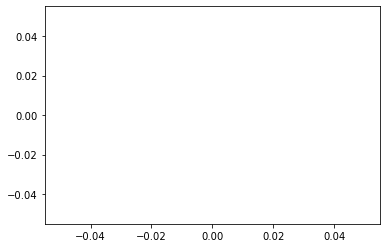

In [31]:
plt.scatter(y=merged_clean["Boxcox Longevity"], x=merged_clean["Release Week"])

<AxesSubplot:>

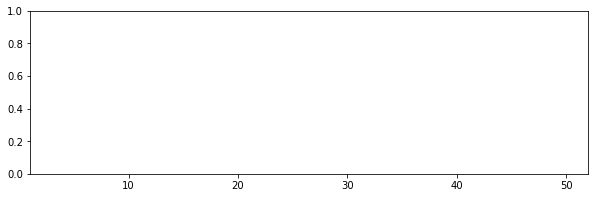

In [24]:
plt.figure(figsize=(10, 3))
plt.xlim(1,52)
sns.lineplot(data=merged_clean, y="Longevity", x="Release Week", color=friendlyred)

/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot:>

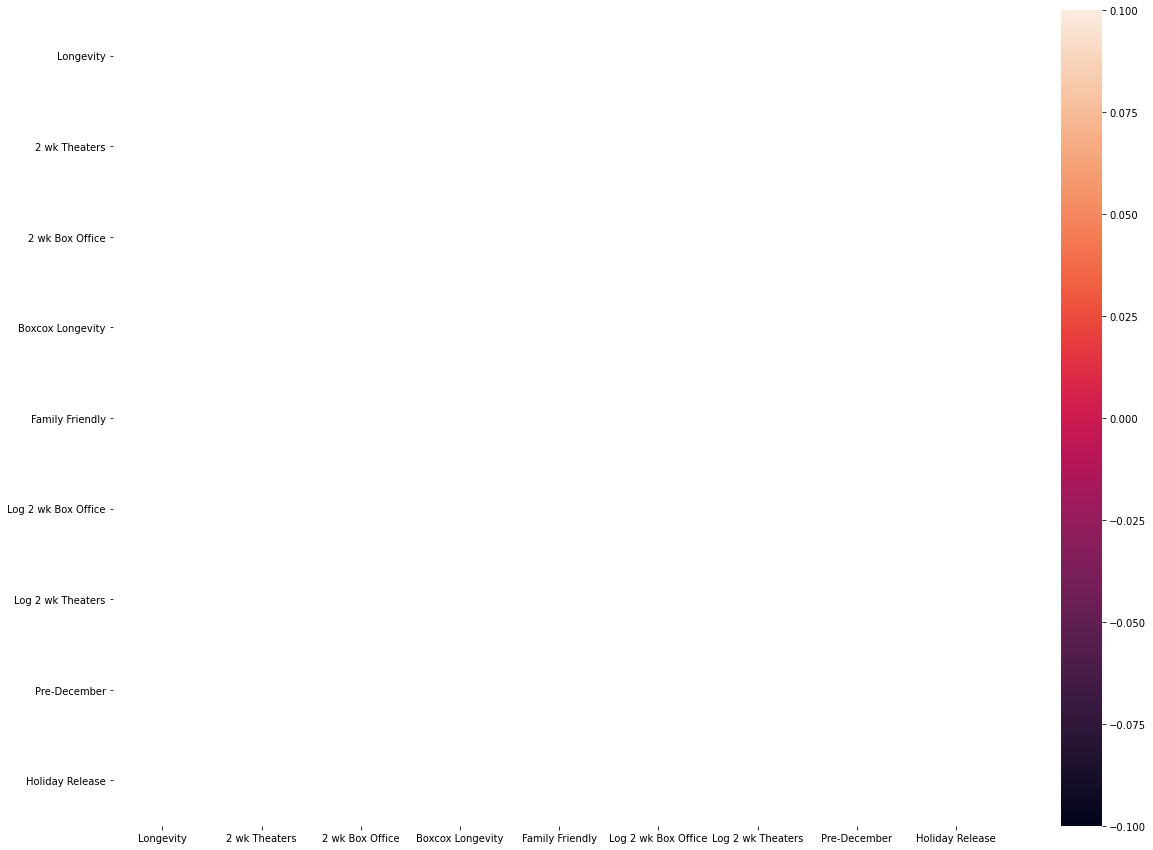

In [25]:
plt.subplots(figsize=(20, 15))
sns.heatmap(merged_clean.corr())

In [26]:
#Now, the actual analysis aspect.

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_error

s = StandardScaler()

scaled_df = pd.DataFrame(data=s.fit_transform(merged_clean), columns=merged_clean.columns)

base_features = scaled_df.drop(columns=["Boxcox Longevity", "Longevity"])
target_var = merged_clean["Boxcox Longevity"]



pf = PolynomialFeatures(2, interaction_only = True)
p_features = pf.fit_transform(base_features)


X_train, X_test, y_train, y_test = train_test_split(base_features, target_var, test_size=0.2, random_state=43)

ValueError: Found array with 0 sample(s) (shape=(0, 29)) while a minimum of 1 is required by StandardScaler.

In [ ]:

ridge = RidgeCV() #max_iter=2000
ridge.fit(X_train, y_train)
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

In [27]:

num_weeks_real =inv_boxcox(y_test, lamb)
num_weeks_estimated = inv_boxcox(ridge.predict(X_test), lamb)


residual_ = num_weeks_estimated-num_weeks_real
plt.figure(figsize=(6,5))
plt.xlim(0, 30)
plt.ylim(0, 25)
plt.scatter(y=num_weeks_estimated, x=num_weeks_real, color=friendlyred);
plt.xlabel("Actual Movie Longevity (Weeks)", fontsize="x-large")
plt.ylabel("Estimated Movie Longevity (Weeks)",fontsize="x-large")
plt.title("Scoring ",fontsize="x-large")

NameError: name 'y_test' is not defined

In [264]:
print(mean_absolute_error(num_weeks_real, num_weeks_estimated))

2.7880174956153403

((array([-3.46794906, -3.22199836, -3.08586493, ...,  3.08586493,
          3.22199836,  3.46794906]),
  array([-2.18040463, -2.18040463, -2.18040463, ...,  8.51553848,
          8.51553848,  8.51553848])),
 (1.7202354269429736, 3.1671581683091956, 0.9946343465640367))

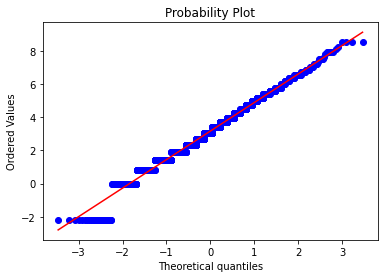

In [248]:
scp.probplot(merged_clean["Boxcox Longevity"], dist="norm", plot=plt)

In [232]:
np.array(list(zip(pf.get_feature_names(base_features.columns), ridge.coef_)))[abs(ridge.coef_)>0.0000001]

array([['1', '0.3957797750354817'],
       ['2 wk Theaters', '-0.018538653138823802'],
       ['2 wk Box Office', '-0.01358286465409897'],
       ['Action', '0.016607541510822887'],
       ['Adventure', '0.0010716123021143886'],
       ['Animation', '0.06884016709841823'],
       ['Biography', '0.03329869400741106'],
       ['Comedy', '-0.02115124001161628'],
       ['Crime', '-0.06092135125114062'],
       ['Documentary', '-0.08233095535463353'],
       ['Drama', '0.028965459791534087'],
       ['History', '-0.06585141854756138'],
       ['Horror', '0.01186819316252119'],
       ['Music', '-0.007858036466313223'],
       ['Musical', '0.004885725979467237'],
       ['Mystery', '-0.039531535342684554'],
       ['News', '-0.055978113328516876'],
       ['Romance', '-0.05606188953836222'],
       ['Sci-Fi', '0.044533052364185366'],
       ['Thriller', '0.03786601327214267'],
       ['War', '-0.02654468425013823'],
       ['Western', '0.04367938209434219'],
       ['G', '-0.018125304972338